### The research paper referenced: 
#### Koch, Gregory et al. "Siamese Neural Networks for One-shot Image Recognition" 

# Setup

## Install and import dependencies

In [1]:
!pip install tensorflow==2.10.0 opencv-python matplotlib

## Import Dependencies

In [1]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# Import tensorflow dependencies - Funtional API
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten # Layer allows me to create a custom layer

### * GPU not set up

In [3]:
# Path to the folders
positive_path = os.path.join('data','positive')
negative_path = os.path.join('data','negative')
anchor_path = os.path.join('data','anchor')

In [11]:
# Make directories -- already created -- uncomment later
os.makedirs(positive_path)
os.makedirs(negative_path)
os.makedirs(anchor_path)

## Load and preprocess images

In [4]:
# shuffle=False to load the files in order
anchor = tf.data.Dataset.list_files(anchor_path+'\*.jpg', shuffle=False).take(950)
positive = tf.data.Dataset.list_files(positive_path+'\*.jpg', shuffle=False).take(950)
negative = tf.data.Dataset.list_files(negative_path+'\*.jpg').take(950)

## Preprocessig - scale & resize

In [5]:
def preprocess(file_path):
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image
    img = tf.io.decode_jpeg(byte_img)
    # Preprocessing steps - resizing the image to be 105x105
    img = tf.image.resize(img, (105,105))
    # Scale image to be between 0 and 1
    img = img / 255.0
    
    # Return iimage
    return img

## Create labelled dataset

In [23]:
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0

In [6]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

## Build train and test partition

In [7]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [8]:
# Build dataloader pipeline
data = data.map(preprocess_twin) # runs the preprocess_twin function
data = data.cache()
data = data.shuffle(buffer_size=1024) 

In [9]:
# Training partition
train_data = data.take(round(len(data)*7))
train_data = train_data.batch(10) 
train_data = train_data.prefetch(5) 

In [10]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(10)
test_data = test_data.prefetch(5)

# Model Engineering

## Build embedding layer

In [15]:
def make_embedding():
    inp = Input(shape=(105,105,3), name='input_image')
    
    # 1st block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # 2nd block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # 3rd block
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # 4th (final) block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [16]:
embedding = make_embedding()
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 105, 105, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 96, 96, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 42, 42, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 21, 21, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 18, 18, 128)       26

## Build distance layer

In [17]:
# Create Siamese L1 distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
    
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [18]:
l1 = L1Dist()

In [19]:
l1

## Make siamese model

In [20]:
def make_siamese_model():
    
    # anchor impage input in the network
    input_image = Input(name='input_img', shape=(105,105,3))
    
    # Validation image in the network
    validation_image = Input(name='validation_img', shape=(105,105,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')


In [21]:
siamese_model = make_siamese_model()
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

# Training

## Set up loss and optimizer

In [22]:
binary_cross_loss = tf.losses.BinaryCrossentropy() ## can be ...Entrpy(from_logits=True) -- recommended when the inputs to the loss function are not normalized

In [23]:
opt = tf.keras.optimizers.Adam(1e-4) 

## Establish checkpoints

In [24]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

## Build train step function
####    Basic flow for training on one batch is 
#####     1. Make a prediction
#####     2. Calculate loss
#####     3. Derive gradients
#####     4. Calculate new weights and apply

In [25]:
@tf.function ## compiling what is happening in the def below
def train_step(batch):
    
    # Record all of our operations
    with tf.GradientTape() as tape: ##  record operations for automatic differentiation - get gradient
        
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]

        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    
    # Return loss
    return loss

## Build training loop

In [26]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
    
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            train_step(batch)
            progbar.update(idx+1)
        
        # Save checkpoints
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

## Train the model

In [27]:
EPOCHS = 20

In [28]:
train(train_data, EPOCHS)


 Epoch 1/20
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
190/190 [==============================] - 1939s 10s/step

 Epoch 2/20
190/190 [==============================] - 1976s 10s/step

 Epoch 3/20
190/190 [==============================] - 1995s 11s/step

 Epoch 4/20
190/190 [==============================] - 1960s 10s/step

 Epoch 5/20
190/190 [==============================] - 1961s 10s/step

 Epoch 6/20
190/190 [==============================] - 2062s 11s/step

 Epoch 7/20
190/190 [==============================] - 2075s 11s/step

 Epoch 8/20
190/190 [==============================] - 2072s 11s/step

 Epoch 9/20
190/190 [==============================] - 2077s 11s/step

 Epoch 10/20
190/190 [==============================] - 2078s 11s/step

 Epoch 11/20
190/190 [==============================] - 2085s 11s/step

 Epoch 12/20
190/190 [==============================] - 1994s 

# Evaluate Model

## Import metrics

In [34]:
# Iport metric dalculations
from tensorflow.keras.metrics import Precision, Recall

## Make predictions

In [37]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [38]:
# Make predictions
y_hat = siamese_model.predict([test_input, test_val])
y_hat

1/1 [==============================] - 5s 5s/step


array([[9.9128622e-05],
       [6.3481480e-01],
       [4.5719122e-07],
       [1.1853104e-01],
       [8.7134123e-01],
       [8.9921938e-05],
       [2.8194563e-04],
       [7.2599214e-01],
       [1.0068423e-04],
       [6.9507897e-01]], dtype=float32)

In [39]:
# Post processing the results
[1 if prediction > 0.5 else 0 for prediction in y_hat]

[0, 1, 0, 0, 1, 0, 0, 1, 0, 1]

In [40]:
y_true

array([0., 1., 0., 1., 1., 0., 0., 1., 0., 1.], dtype=float32)

## Calculate metrics

In [41]:
# Creating a metric object
m = Recall()

# Calculating the recall value
m.update_state(y_true,y_hat)

# Return recall result
m.result().numpy()

0.8

In [42]:
m = Precision()
m.update_state(y_true, y_hat)
m.result().numpy()

1.0

## Visualize results

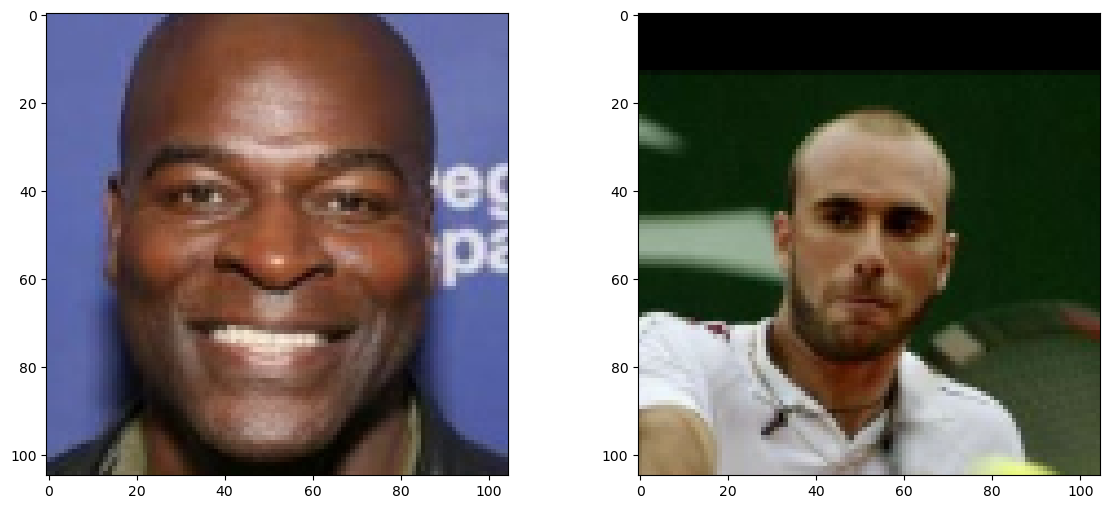

In [48]:
# Set plot size
plt.figure(figsize=(14,6))

# Set first subplot
plt.subplot(1,2,1) ## 1 row, 2 columns, 1st image
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1,2,2) ## 1 row, 2 columns, 2nd image
plt.imshow(test_val[0])
plt.show()